In [3]:
from itertools import islice, combinations, product
from collections import defaultdict
from goatools import obo_parser
from functools import partial

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [4]:
%matplotlib inline
sns.set()

DATA_DIRECTORY = "/media/clusterduck123/joe/data"
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw-data"
YEAST_DIRECTORY = f"{DATA_DIRECTORY}/processed-data/organisms/yeast"
ENRICHMENT_DIRECTORY = f"{YEAST_DIRECTORY}/enrichments"

aspects   = ['CC', 'BP', 'MF']
coverages = ['clusters', 'GO-terms', 'genes']

# Load

In [5]:
data_dictionary = {}

for feature in os.listdir(ENRICHMENT_DIRECTORY):
    data_dictionary[feature] = dict()
    for distance in os.listdir(  f"{ENRICHMENT_DIRECTORY}/{feature}"):
        data_dictionary[feature][distance] = dict()
        for aspect in os.listdir(f"{ENRICHMENT_DIRECTORY}/{feature}/{distance}/kmedoid"):
            data_dictionary[feature][distance][aspect] = dict()
            for correction in os.listdir(f"{ENRICHMENT_DIRECTORY}/{feature}/{distance}/kmedoid/{aspect}"):
                data_dictionary[feature][distance][aspect][correction] = dict()
                for coverage in coverages:
                    df = pd.read_csv(f"{ENRICHMENT_DIRECTORY}/{feature}/{distance}/kmedoid/{aspect}/{correction}/{coverage}.csv", 
                                     index_col=0)
                    data_dictionary[feature][distance][aspect][correction][coverage] = df

# Plots

In [6]:
def my_plot(ax, feature, distance, correction, coverage,
            ncol = 2):
    ax.plot(df.index, 100*df.T.mean(), 
                        label     = f'{feature} ${distance}$',
                        linewidth = 2.5,
                        alpha     = 0.75);

    ax.fill_between(df.index, 100*df.T.quantile(0.25), 100*df.T.quantile(0.75), 
                    alpha=0.1,);

    ax.set_title(f'{coverage} enriched ({correction})', fontsize=28)

    ax.patch.set_alpha(0)

    ax.set_xlabel(f'# {coverage}', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')

    ax.legend(fontsize=14, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=ncol);

## 9 Plots

In [18]:
feature_distances = [
    ('GDV', 'GDV-similarity'),
    ('GDV','mahalanobis'), 
    #('GDV','seuclidean'), 
    
    #('GDV', 'normalized1-l1'), 
    ('GDV', 'normalized1-l2'),
    #('GDV', 'normalized1-linf'),
    
    #('GDV', 'normalized2-l1'), 
    #('GDV', 'normalized2-l2'),
    #('GDV', 'normalized2-linf'),
   
    #('GDV', 'cityblock'),
    #('GDV', 'euclidean'),
    #('GDV', 'chebyshev'),
    #('GDV', 'sqeuclidean'),
    
    #('GDV', 'cosine'),
    #('GDV', 'correlation'),
    
    #('GDV', 'braycurtis'),
    #('GDV', 'canberra'),
    
    
    #('GCV-A', 'normalized1-l1'), 
    #('GCV-A', 'normalized1-l2'),
    #('GCV-A', 'normalized1-linf'),
    #
    #('GCV-G', 'normalized1-l1'), 
    #('GCV-G', 'normalized1-l2'),
    #('GCV-G', 'normalized1-linf'),
    
    #('GCV-AD', 'normalized1-l1'), 
    #('GCV-AD', 'normalized1-l2'),
    #('GCV-AD', 'normalized1-linf'),
    #
    #('GCV-DG', 'normalized1-l1'), 
    #('GCV-DG', 'normalized1-l2'),
    #('GCV-DG', 'normalized1-linf'),
    
                        ]

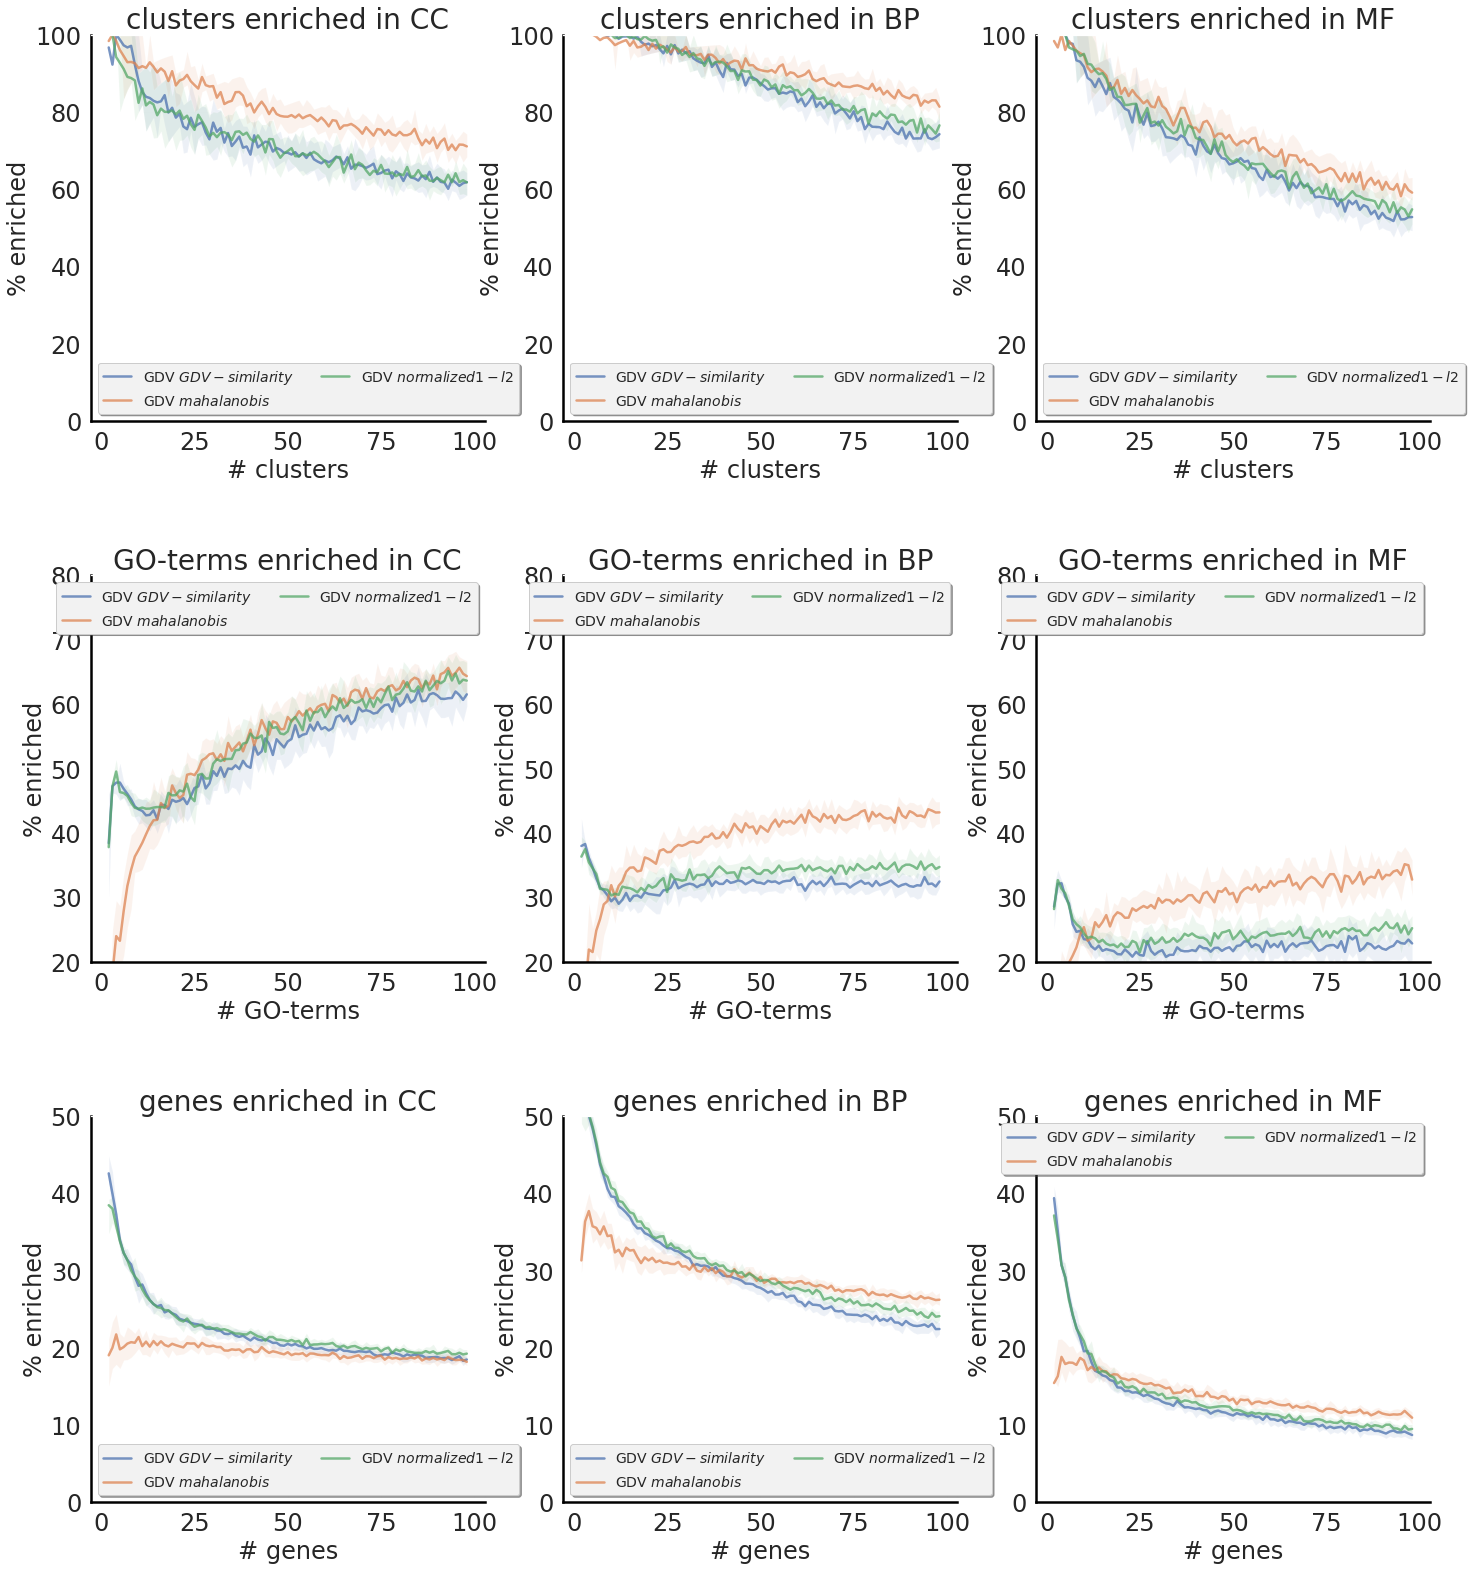

In [19]:
figname = 'all'
fig, axes = plt.subplots(3,3,figsize=(24,27))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

correction = 'BH'

for feature, distance in feature_distances:
    for i, coverage in enumerate(coverages):
        for j, aspect in enumerate(aspects):
            data_dictionary[feature][distance][aspect]
            df = data_dictionary[feature][distance][aspect][correction][coverage]
            my_plot(ax = axes[i,j],
                    feature    = feature,
                    distance   = distance,
                    correction = correction,
                    coverage   = coverage,
                    ncol = 2)
            
            axes[i,j].set_title(f'{coverage} enriched in {aspect}', fontsize=28)
            if   i == 0:
                axes[i,j].set_ylim(0,100)
            elif i == 1:
                axes[i,j].set_ylim(20,80)
            elif i == 2:
                axes[i,j].set_ylim(0,50)

## One Aspect

In [11]:
feature_distances = [
    ('GDV','mahalanobis'), 
    ('GDV', 'GDV-similarity'),
    #
    #('GDV', 'normalized1-l1'), 
    #('GDV', 'normalized1-l2'),
    #('GDV', 'normalized1-linf'),
    
    #('GDV', 'cityblock'),
    #('GDV', 'euclidean'),
    #('GDV', 'chebyshev'),
    
    
    #('GDV-A', 'normalized1-l1'), 
    #('GDV-A', 'normalized1-l2'),
    #('GDV-A', 'normalized1-linf'),
    #
    #('GDV-G', 'normalized1-l1'), 
    #('GDV-G', 'normalized1-l2'),
    #('GDV-G', 'normalized1-linf'),
    
    #('GDV-AD', 'normalized1-l1'), 
    #('GDV-AD', 'normalized1-l2'),
    #('GDV-AD', 'normalized1-linf'),
    
    ('GDV-DG', 'normalized1-l1'), 
    ('GDV-DG', 'normalized1-l2'),
    ('GDV-DG', 'normalized1-linf'),
    
                        ]

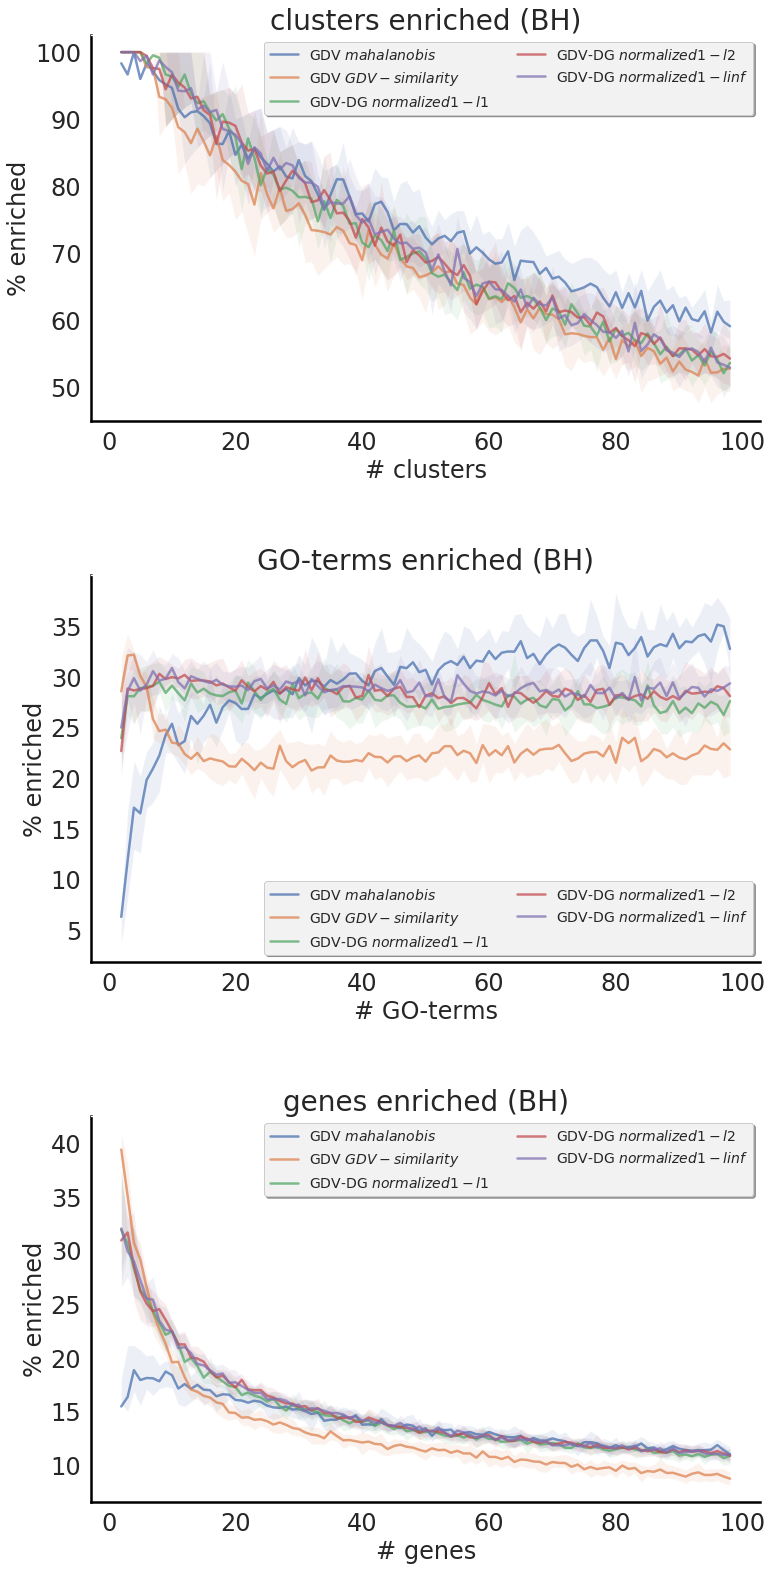

In [15]:
figname = 'all'
fig, axes = plt.subplots(3,1, figsize=(12,27))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

correction = 'BH'
aspect = 'MF'

for feature, distance in feature_distances:
            for i,coverage in enumerate(coverages):
                df = data_dictionary[feature][distance][aspect][correction][coverage]
                my_plot(ax = axes[i],
                        feature    = feature,
                        distance   = distance,
                        correction = correction,
                        coverage   = coverage)

## clusters

In [ ]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

for method in plot_methods:
    feature  = method.split('_')[0]
    distance = '_'.join(method.split('_')[1:])
    
    ax.plot(cluster_coverages[feature][distance].index, 100*cluster_coverages[feature][distance].T.mean(), 
            label     = f'${name2string[method]}$', 
            color    = colors[method], 
            linewidth = 2.5,
            alpha     = 0.75);
    
    ax.fill_between(cluster_coverages[feature][distance].index, 
                     100*cluster_coverages[feature][distance].T.quantile(0.25), 
                     100*cluster_coverages[feature][distance].T.quantile(0.75), 
                     color    = colors[method],
                     alpha=0.1,);
    ax.set_title(f'Clusters enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=2);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_cluster.png")

In [17]:
name2string = {'GCV_tvd':'TVD', 'GCV_hellinger':'GCV_{hell}', 'GDV_GDV-similarity':'GDV-similiarity',
               
               'GDV_euclidean'  :'GDV_{L_2}'  , 'GCV_euclidean'  :'GCV_{eucl}'  , 
               'GDV_cityblock'  :'GDV_{L_1}'  , 'GCV_cityblock'  :'GCV_{city}'  , 
               'GDV_seuclidean' :'GDV_{seucl}' , 'GCV_seuclidean' :'GCV_{seucl}' ,
               'GDV_cosine'     :'GDV_{cos}'   , 'GCV_cosine'     :'GCV_{cos}'   ,
               'GDV_correlation':'GDV_{cor}'   , 'GCV_correlation':'GCV_{cor}'   ,
               'GDV_sqeuclidean':'GDV_{eucl^2}', 'GCV_sqeuclidean':'GCV_{eucl^2}',
               'GDV_chebyshev'  :'GDV_{L_{\infty}}' , 'GCV_chebyshev'  :'GCV_{cheby}' ,
               'GDV_canberra'   :'GDV_{can}'   , 'GCV_canberra'   :'GCV_{can}'   ,
               'GDV_braycurtis' :'GDV_{bray}'  , 'GCV_braycurtis' :'GCV_{bray}'  ,
               'GDV_mahalanobis':'GDV_{mahala}', 'GCV_mahalanobis':'GCV_{mahala}',
               
               'GDV_normalized1-l1': 'GDV_{nL_1}',
               'GDV_normalized1-l2': 'GDV_{nL_2}',
               'GDV_normalized1-linf': 'GDV_{nL_{\infty}}',
              
               
               'GCV-A_normalized1-l1'  : 'GCV-A_{nL_1}',
               'GCV-A_normalized1-l2'  : 'GCV-A_{nL_2}',
               'GCV-A_normalized1-linf': 'GCV-A_{nL_{\infty}}',
               
               'GCV-G_normalized1-l1'  : 'GCV-G_{nL_1}',
               'GCV-G_normalized1-l2'  : 'GCV-G_{nL_2}',
               'GCV-G_normalized1-linf': 'GCV-G_{nL_{\infty}}',

               'GCV-DG_normalized1-l1'  : 'GCV-DG_{nL_1}',
               'GCV-DG_normalized1-l2'  : 'GCV-DG_{nL_2}',
               'GCV-DG_normalized1-linf': 'GCV-DG_{nL_{\infty}}',
              
               'GCV-AD_normalized1-l1'  : 'GCV-AD_{nL_1}',
               'GCV-AD_normalized1-l2'  : 'GCV-AD_{nL_2}',
               'GCV-AD_normalized1-linf': 'GCV-AD_{nL_{\infty}}',}

In [31]:
plot_methods = [
                #'GDV_mahalanobis',
                #'GDV_GDV-similarity',
    
                #'GDV_cityblock',
                #'GDV_euclidean',
                #'GDV_chebyshev',
                
                #'GDV_normalized1-l1',
                #'GDV_normalized1-l2',
                #'GDV_normalized1-linf',
    
                'GCV-A_normalized1-l1',
                'GCV-A_normalized1-l2',
                'GCV-A_normalized1-linf',
    
                'GCV-G_normalized1-l1',
                'GCV-G_normalized1-l2',
                'GCV-G_normalized1-linf',
    
                #'GCV-DG_normalized1-l1',
                #'GCV-DG_normalized1-l2',
                #'GCV-DG_normalized1-linf',
    
                #'GCV-AD_normalized1-l1',
                #'GCV-AD_normalized1-l2',
                #'GCV-AD_normalized1-linf'

               ]

In [32]:
blues = sns.color_palette("Blues", 3)
reds  = sns.color_palette("Reds" , 3)
blacks= sns.color_palette("Greys" , 3)
whateva = sns.hls_palette(8, l=.3, s=.8)

colors = {
           'GDV_mahalanobis'   : whateva[0],
           'GDV_GDV-similarity': whateva[1],
    
           'GDV_cityblock' : whateva[7],
           'GDV_euclidean' : whateva[5],
           'GDV_chebyshev' : whateva[3],
                
           'GDV_normalized1-l1'  : whateva[7],
           'GDV_normalized1-l2'  : whateva[5],
           'GDV_normalized1-linf': whateva[3],
    
           #'GDV_canberra'
    
           'GCV-A_normalized1-l1' : blues[0],
           'GCV-A_normalized1-l2' : blues[1],
           'GCV-A_normalized1-linf' : blues[2],
    
           'GCV-G_normalized1-l1' : reds[0],
           'GCV-G_normalized1-l2' : reds[1],
           'GCV-G_normalized1-linf' : reds[2],
            
           'GCV-DG_normalized1-l1' : blacks[2],
           'GCV-DG_normalized1-l2' : blacks[0],
           'GCV-DG_normalized1-linf' : blacks[0],
               }

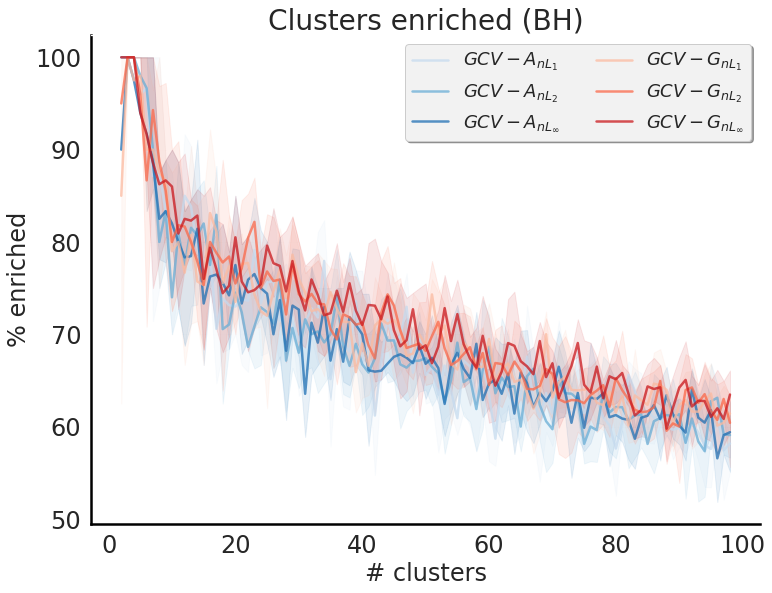

In [33]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    feature  = method.split('_')[0]
    distance = '_'.join(method.split('_')[1:])
    
    ax.plot(cluster_coverages[feature][distance].index, 100*cluster_coverages[feature][distance].T.mean(), 
            label     = f'${name2string[method]}$', 
            color    = colors[method], 
            linewidth = 2.5,
            alpha     = 0.75);
    
    ax.fill_between(cluster_coverages[feature][distance].index, 
                     100*cluster_coverages[feature][distance].T.quantile(0.25), 
                     100*cluster_coverages[feature][distance].T.quantile(0.75), 
                     color    = colors[method],
                     alpha=0.1,);
    ax.set_title(f'Clusters enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=2);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_cluster.png")

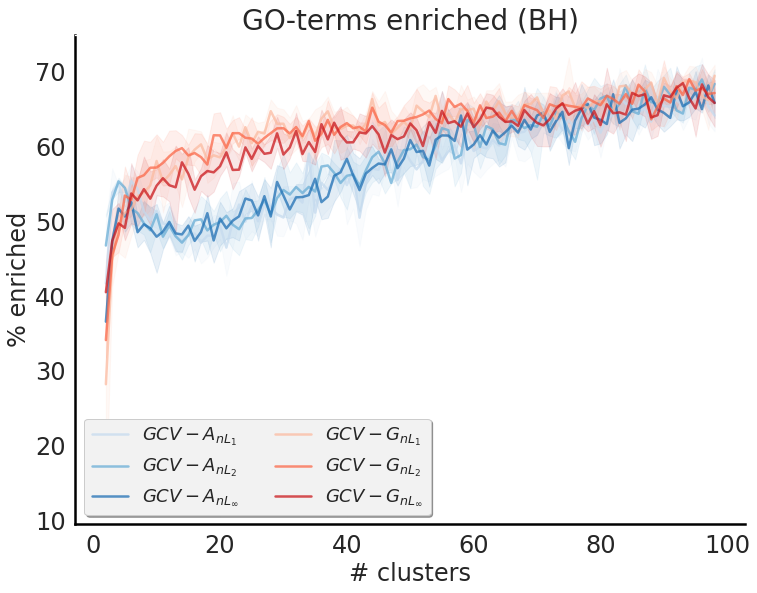

In [34]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    feature  = method.split('_')[0]
    distance = '_'.join(method.split('_')[1:])
    
    ax.plot(GO_coverages[feature][distance].index, 100*GO_coverages[feature][distance].T.mean(), 
            label = f'${name2string[method]}$', 
            color = colors[method], 
            alpha = 0.75,
            linewidth=2.5);
    
    ax.fill_between(GO_coverages[feature][distance].index, 
                     100*GO_coverages[feature][distance].T.quantile(0.25), 
                     100*GO_coverages[feature][distance].T.quantile(0.75), 
                     color = colors[method], 
                     alpha = 0.1,);
    ax.set_title(f'GO-terms enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=2);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_GO-term.png")

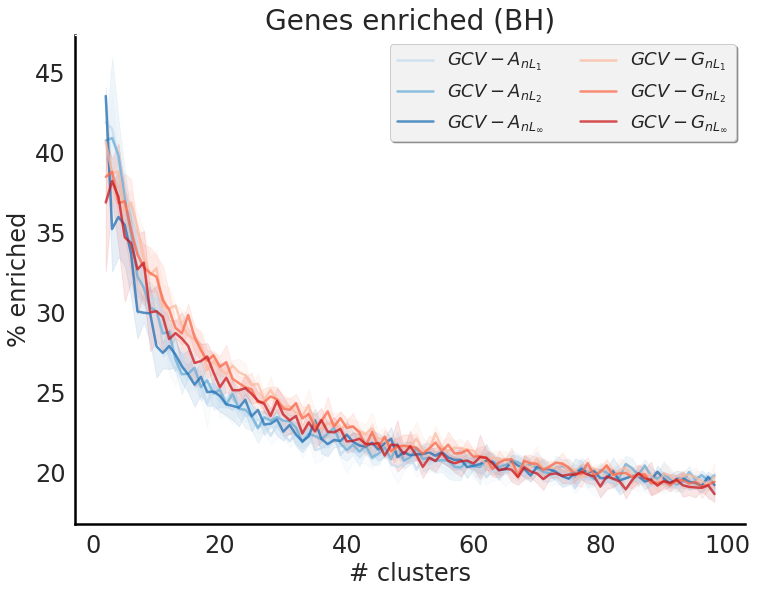

In [35]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    
    feature  = method.split('_')[0]
    distance = '_'.join(method.split('_')[1:])
    
    ax.plot(gene_coverages[feature][distance].index, 100*gene_coverages[feature][distance].T.mean(), 
            label=f'${name2string[method]}$', 
            color = colors[method], 
            alpha = 0.75,
            linewidth = 2.5);
    
    ax.fill_between(gene_coverages[feature][distance].index,
                     100*gene_coverages[feature][distance].T.quantile(0.25), 
                     100*gene_coverages[feature][distance].T.quantile(0.75), 
                     color = colors[method], 
                     alpha = 0.1,);
    ax.set_title(f'Genes enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=2);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_gene.png")